# Analysis of ChIP-seq simulation

See 2023_chips for scripts.
Peak calling important: keep fixed settings.

```
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True span=False sicer=False --rerun-trigger mtime;
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams macs2=True macs2_mode=broad macs2_params="--broad --broad-cutoff=0.1" macs2_suffix="broad0.1"  span=False sicer=False --rerun-trigger mtime; 
snakemake -p -s ~/work/chipseq-smk-pipeline/Snakefile all --cores all  --use-conda  --directory $(pwd) --config genome=hg38 fastq_dir=$(pwd) start_with_bams=True bams_dir=bams bamCoverage_params="--ignoreDuplicates" span=True sicer=True span_bin=100 span_params="--keep-cache --debug --noclip --blacklist /home/jetbrains/data/2023_wiggle/hg38-blacklist.v2.bed" --rerun-trigger mtime

```

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

import os

import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
sns.set_style("whitegrid")
import tempfile
import numpy as np

In [2]:
PATH = os.path.expanduser('~/data/2023_chips')
N = 5
MULTIPLIERS = [1.0, 0.7, 0.5, 0.2, 0.1]

FIGURES_DIR = f'{PATH}/pics'
! mkdir -p {FIGURES_DIR}
! rm {FIGURES_DIR}/*

# Chips models analysis

In [3]:
import json

models_df = pd.DataFrame(columns=['Modification', 'Model', 'k', 'theta', 'prc_rate', 'f', 's'],
                         dtype=object)
for modification in ['H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me3']:
    path = os.path.join(PATH, 'models', f'{modification}.json')
    with open(path) as f:
        m = json.load(f)
        k, theta, prc_rate, f, s = m['frag']['k'], m['frag']['theta'], m['pcr_rate'], \
            m['pulldown']['f'], m['pulldown']['s']
        models_df.loc[len(models_df)] = (modification, path, k, theta, prc_rate, f, s)
models_df.to_csv(os.path.join(PATH, 'models.tsv'), sep='\t', index=None)
models_df

Modification                                              Model         k  \
0      H3K27ac  /home/jetbrains/data/2023_chips/models/H3K27ac...  9.698845   
1     H3K27me3  /home/jetbrains/data/2023_chips/models/H3K27me...  7.710403   
2     H3K36me3  /home/jetbrains/data/2023_chips/models/H3K36me...  8.121823   
3      H3K4me1  /home/jetbrains/data/2023_chips/models/H3K4me1...  7.084311   
4      H3K4me3  /home/jetbrains/data/2023_chips/models/H3K4me3...  5.655991   

       theta  prc_rate         f         s  
0  28.720036       1.0  0.016691  0.543023  
1  32.211166       1.0  0.003799  0.186056  
2  31.384718       1.0  0.021185  0.649353  
3  33.604404       1.0  0.016509  0.742254  
4  37.608902       1.0  0.005437  0.738595

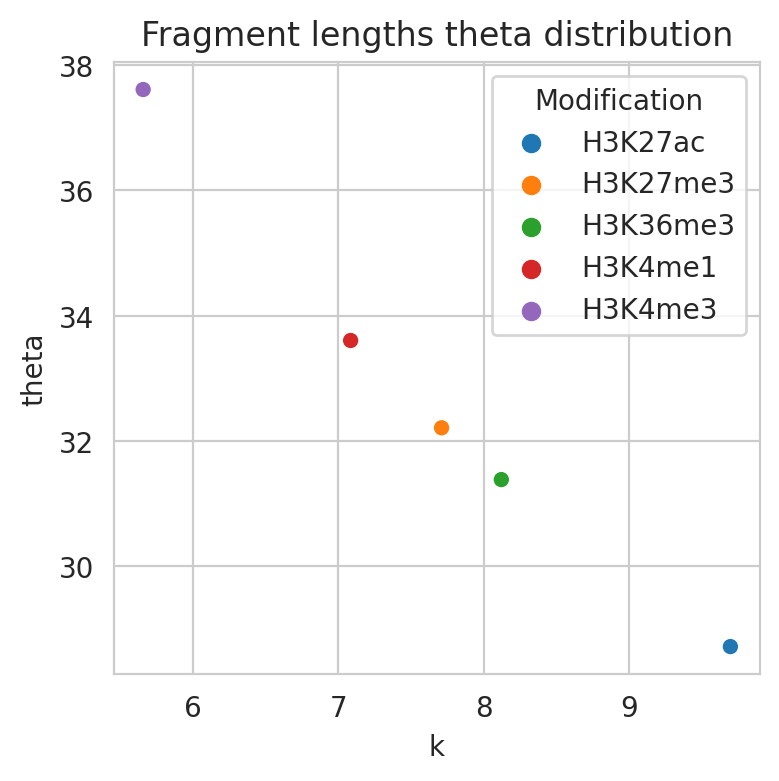

In [4]:
fig = plt.figure(figsize=(4, 4))
sns.scatterplot(data=models_df, x='k', y='theta', hue='Modification', markers=True)
plt.title(f'Fragment lengths theta distribution')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'models_fragments_theta.pdf'), bbox_inches='tight', dpi=300)
plt.show()

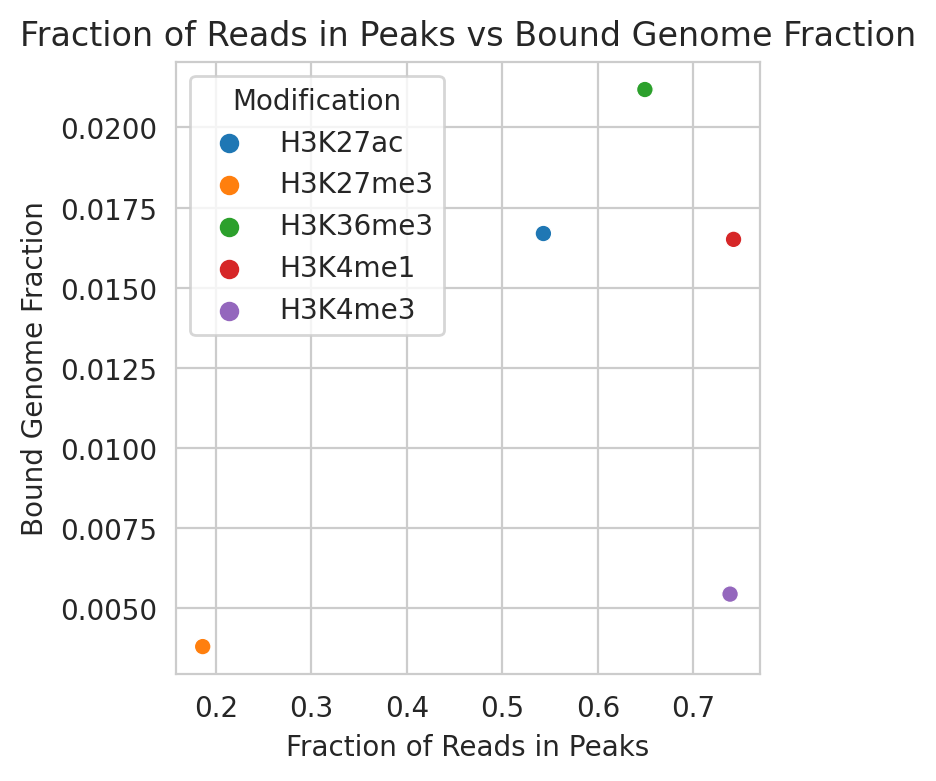

In [5]:
fig = plt.figure(figsize=(4, 4))
sns.scatterplot(data=models_df, x='s', y='f', hue='Modification', markers=True)
plt.title(f'Fraction of Reads in Peaks vs Bound Genome Fraction')
plt.xlabel('Fraction of Reads in Peaks')
plt.ylabel('Bound Genome Fraction')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'models_frip_vs_bound_genome.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Report analysis

In [6]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

In [7]:
original_peaks = {
    'H3K4me3': PATH + '/peaks/H3K4me3_q0.05_peaks.narrowPeak',
    'H3K27ac': PATH + '/peaks/H3K27ac_broad0.1_peaks.broadPeak',
    'H3K4me1': PATH + '/peaks/H3K4me1_broad0.1_peaks.broadPeak',
    'H3K27me3' : PATH + '/peaks/H3K27me3-W200-G600-islands-summary-FDR0.01',
    'H3K36me3': PATH + '/peaks/H3K36me3-W200-G600-islands-summary-FDR0.01',
}

In [8]:
import glob
sampled_peaks = {}
for m in ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed']:
    for n in range(1, N + 1):
        sampled_peaks[(m, n)] = glob.glob(PATH + f'/fastq/{m}_*_{n}.bed')[0]
sampled_peaks

{('H3K4me3', 1): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_1.bed',
 ('H3K4me3', 2): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_2.bed',
 ('H3K4me3', 3): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_3.bed',
 ('H3K4me3', 4): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_4.bed',
 ('H3K4me3', 5): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_5.bed',
 ('H3K27ac', 1): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_1.bed',
 ('H3K27ac', 2): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_2.bed',
 ('H3K27ac', 3): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_3.bed',
 ('H3K27ac', 4): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_4.bed',
 ('H3K27ac', 5): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_5.bed',
 ('H3K4me1', 1): '/home/jetbrains/data/2023_chips/fastq/H3K4me1_chr15_1.bed',
 ('H3K4me1', 2): '/home/jetbrains/data/2023_chips/fastq/H3K4me1_chr15_2.bed',
 ('H3K4me1', 3): '/home/jetbrains/data/2023_chips/fastq/H3K4me1_

In [32]:
from itertools import product
def load_peaks(path, suffix):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'n', 'multiplier'], dtype=object)
    for (m, n, mult) in tqdm(product(
            ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'], 
            range(1, N + 1), 
            MULTIPLIERS)):
        res = glob.glob(f'{path}/{m}*_{n}_{mult}*{suffix}')
        if len(res) > 1:
            print(f'WARNING, more than 1 found for {path} {suffix}')
        for f in res:
            df_fdr.loc[len(df_fdr)] = (f, m, n, mult)
    return df_fdr

# Load peaks

In [33]:
df_macs2 = load_peaks(PATH + '/macs2', '.narrowPeak')
df_macs2['tool'] = 'MACS2'
print('MACS2', len(df_macs2))
df_macs2broad = load_peaks(PATH + '/macs2', '.broadPeak')
df_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_macs2broad))
df_sicer = load_peaks(PATH + '/sicer', 'FDR0.01')
df_sicer['tool'] = 'SICER'
print('SICER', len(df_sicer))
df_span = load_peaks(PATH + '/span', '.peak')
df_span['tool'] = 'SPAN'
print('SPAN', len(df_span))

df_peaks = pd.concat([df_macs2, df_macs2broad, df_span, df_sicer]).reset_index(drop=True)
df_peaks['quality'] = [f'{int(m * 100)}%' for m in df_peaks['multiplier']]
df_peaks.sample(5)

0it [00:00, ?it/s]

MACS2 150


0it [00:00, ?it/s]

MACS2 broad 150


0it [00:00, ?it/s]

SICER 150


0it [00:00, ?it/s]

SPAN 150


file modification  n  \
287  /home/jetbrains/data/2023_chips/macs2/mixed_k4...        mixed  3   
567  /home/jetbrains/data/2023_chips/sicer/H3K36me3...     H3K36me3  4   
24   /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3  5   
330  /home/jetbrains/data/2023_chips/span/H3K27ac_c...      H3K27ac  2   
189  /home/jetbrains/data/2023_chips/macs2/H3K27ac_...      H3K27ac  3   

     multiplier         tool quality  
287         0.5  MACS2 broad     50%  
567         0.5        SICER     50%  
24          0.1        MACS2     10%  
330         1.0         SPAN    100%  
189         0.1  MACS2 broad     10%

# Estimate overlap with ground truth peaks

In [34]:
tf = tempfile.mktemp()
t = []
for _, (file, m, n) in tqdm(df_peaks[['file', 'modification', 'n']].iterrows()):
    true_peaks_file = sampled_peaks[(m, n)]
    true_peaks = lines(true_peaks_file)
    true_length = bedl(true_peaks_file).sum()
    peaks = lines(file)
    length = bedl(file).sum()
    true_peaks_file_s = sorted_file(true_peaks_file)
    file_s = sorted_file(file)
    !bedtools intersect -a {true_peaks_file_s} -b {file_s} -wa -u > {tf}
    true_overlap = lines(tf)
    !bedtools intersect -b {true_peaks_file_s} -a {file_s} -wa -u > {tf}
    overlap = lines(tf)
    !bedtools intersect -a {true_peaks_file_s} -b {file_s} -wo > {tf}
    overlap_len = int(last_col(tf).sum())
    t.append((true_peaks_file, true_peaks, true_length, peaks, length, true_overlap, overlap, overlap_len))
    
t = pd.DataFrame(t, columns=['true_peaks_file', 'true_peaks', 'true_length',
                             'peaks', 'length', 
                             'true_overlap', 'overlap', 'overlap_len'])
for c in t.columns:
    df_peaks[c] = list(t[c])
del t

df_peaks['Precision'] = df_peaks['overlap'] / df_peaks['peaks']
df_peaks['Recall'] = df_peaks['true_overlap'] / df_peaks['true_peaks']
df_peaks['F1'] = [2 / (1 / p + 1 / r) if min(p, r) > 0 else 0 for p, r in zip(df_peaks['Precision'], df_peaks['Recall'])]
df_peaks['Jaccard'] = df_peaks['overlap_len'] / (df_peaks['true_length'] + df_peaks['length'] - df_peaks['overlap_len'])


df_peaks.sample(5)

0it [00:00, ?it/s]

file modification  n  \
247  /home/jetbrains/data/2023_chips/macs2/H3K27me3...     H3K27me3  5   
504  /home/jetbrains/data/2023_chips/sicer/H3K4me1_...      H3K4me1  1   
33   /home/jetbrains/data/2023_chips/macs2/H3K27ac_...      H3K27ac  2   
510  /home/jetbrains/data/2023_chips/sicer/H3K4me1_...      H3K4me1  3   
155  /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3  2   

     multiplier         tool quality  \
247         0.5  MACS2 broad     50%   
504         0.1        SICER     10%   
33          0.2        MACS2     20%   
510         1.0        SICER    100%   
155         1.0  MACS2 broad    100%   

                                       true_peaks_file  true_peaks  \
247  /home/jetbrains/data/2023_chips/fastq/H3K27me3...         500   
504  /home/jetbrains/data/2023_chips/fastq/H3K4me1_...         500   
33   /home/jetbrains/data/2023_chips/fastq/H3K27ac_...         500   
510  /home/jetbrains/data/2023_chips/fastq/H3K4me1_...         500   
155  /home/jetbrains/data/2023_chips/fastq/H3K4me3_...         500   

     true_length  peaks     length  true_overlap  overlap  overlap_len  \
247      3039100    703  2635060.0           416      664      2594958   
504       618764   1786  2846614.0           192      192       360227   
33        553113    264   249435.0           142      261       246846   
510       601688    663  1142537.0           487      487       596794   
155       467024    861   611245.0           404      405       432042   

     Precision  Recall        F1   Jaccard  
247   0.944523   0.832  0.884698  0.842737  
504   0.107503   0.384  0.167979  0.116009  
33    0.988636   0.284  0.441246  0.444206  
510   0.734540   0.974  0.837489  0.520113  
155   0.470383   0.808  0.594610  0.668561

# Peaks number and lengths

In [35]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

/tmp/ipykernel_83572/386494431.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('tab10')


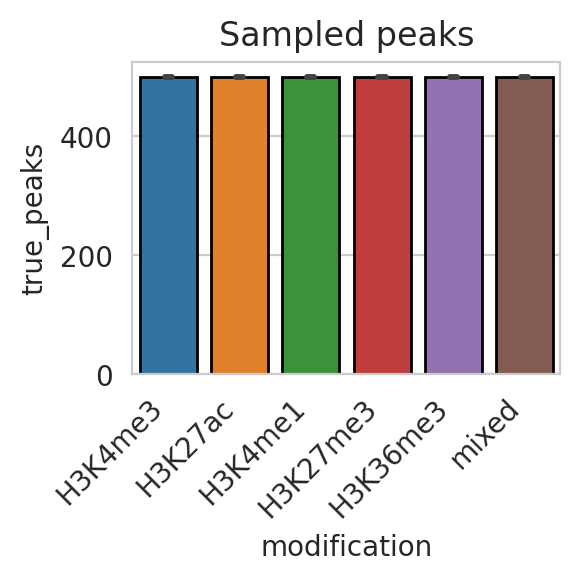

In [36]:
fig = plt.figure(figsize=(3, 3))
sns.barplot(data=df_peaks, x="modification", y="true_peaks",
            capsize=.1, errwidth=2, edgecolor="black",
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
plt.xticks(rotation=45, ha='right')
plt.title('Sampled peaks')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'true_peaks_number.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [37]:
ts = []
for m, file in original_peaks.items():
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 20_000))
    t['modification'] = m
    ts.append(t)
t_original = pd.concat(ts).reset_index(drop=True)
del ts
t_original

length modification
0         939      H3K4me3
1         210      H3K4me3
2        1383      H3K4me3
3         352      H3K4me3
4         749      H3K4me3
...       ...          ...
99995   15199     H3K36me3
99996    3799     H3K36me3
99997   25999     H3K36me3
99998    9999     H3K36me3
99999    9199     H3K36me3

[100000 rows x 2 columns]

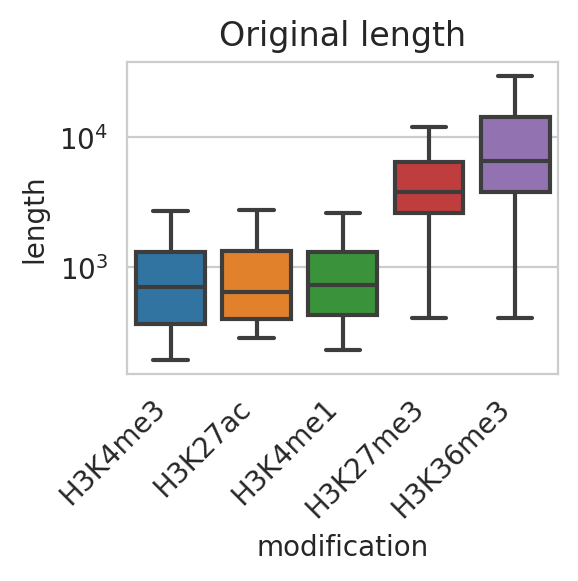

In [38]:
fig = plt.figure(figsize=(3, 3))
ax = plt.axes()
sns.boxplot(data=t_original, x="modification", y="length", showfliers=False,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
            ax=ax)
ax.set(yscale='log')
plt.xticks(rotation=45, ha='right')
plt.title('Original length')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'true_peaks_lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

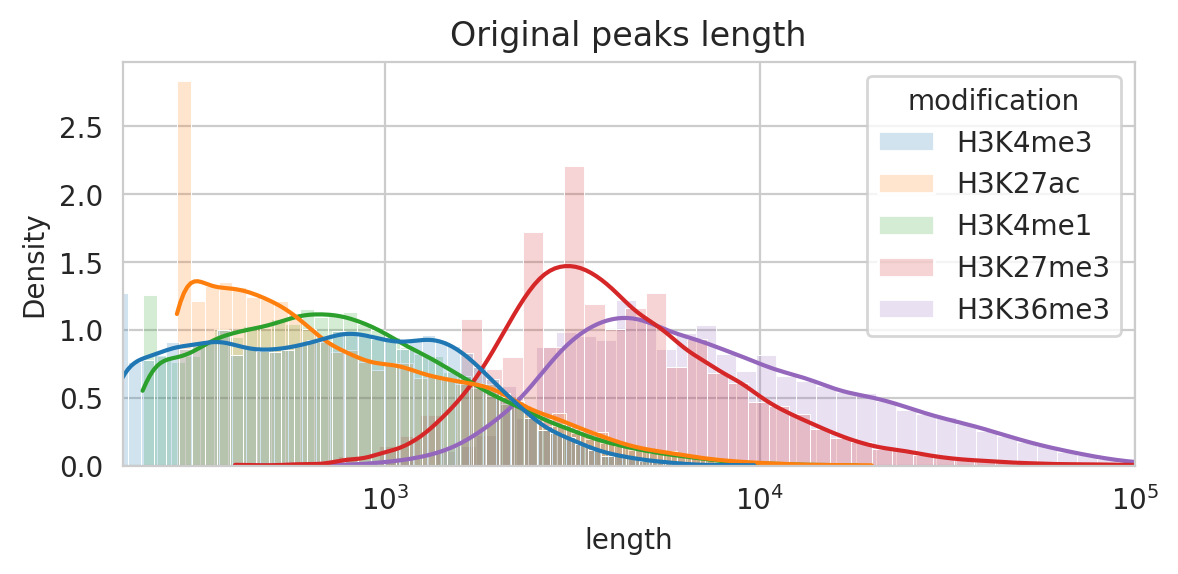

In [39]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
g_results = sns.histplot(data=t_original, x='length', hue='modification', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=50, kde=True, log_scale=True, alpha=0.2,
                         hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'])
g_results.set(xscale='log')
g_results.set_xlim(200, 1e5)
ax.title.set_text('Original peaks length')
plt.savefig(os.path.join(FIGURES_DIR, f'true_peaks_lengths2.pdf'), bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

In [40]:
ts = []
for _, (m, file) in df_peaks[['modification', 'true_peaks_file']].iterrows():
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 20_000))
    t['modification'] = m
    ts.append(t)
t_true_peaks = pd.concat(ts).reset_index(drop=True)
del ts
t_true_peaks

length modification
0         1958      H3K4me3
1          359      H3K4me3
2          538      H3K4me3
3          288      H3K4me3
4         1062      H3K4me3
...        ...          ...
299995    7799        mixed
299996     293        mixed
299997     270        mixed
299998    1953        mixed
299999     629        mixed

[300000 rows x 2 columns]

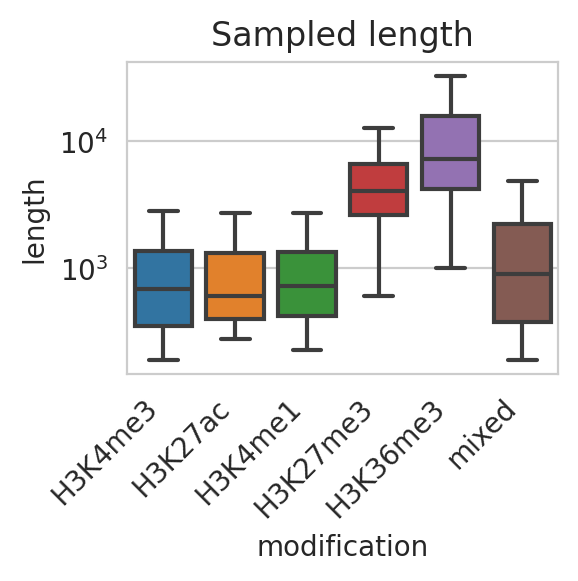

In [41]:
fig = plt.figure(figsize=(3, 3))
g_results = sns.boxplot(data=t_true_peaks, x="modification", y="length", showfliers=False,
               order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
plt.xticks(rotation=45, ha='right')
g_results.set(yscale='log')
plt.title('Sampled length')
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'sampled_peaks_lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

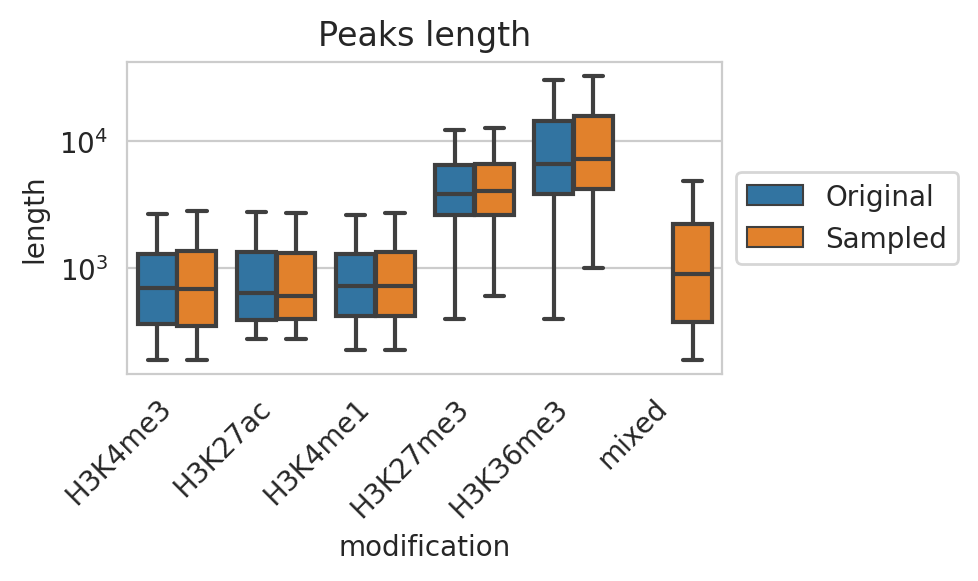

In [42]:
t_original['type'] = 'Original'
t_true_peaks['type'] = 'Sampled'
plt.figure(figsize=(5, 3))
g_results = sns.boxplot(data=pd.concat([t_original, t_true_peaks]).reset_index(drop=True), 
                        x="modification", y="length", showfliers=False,
                        hue='type', hue_order=['Original', 'Sampled'],
                        order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
# Put a legend to the right of the current axix
g_results.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, ha='right')
g_results.set(yscale='log')
plt.title('Peaks length')
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'sampled_peaks_lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

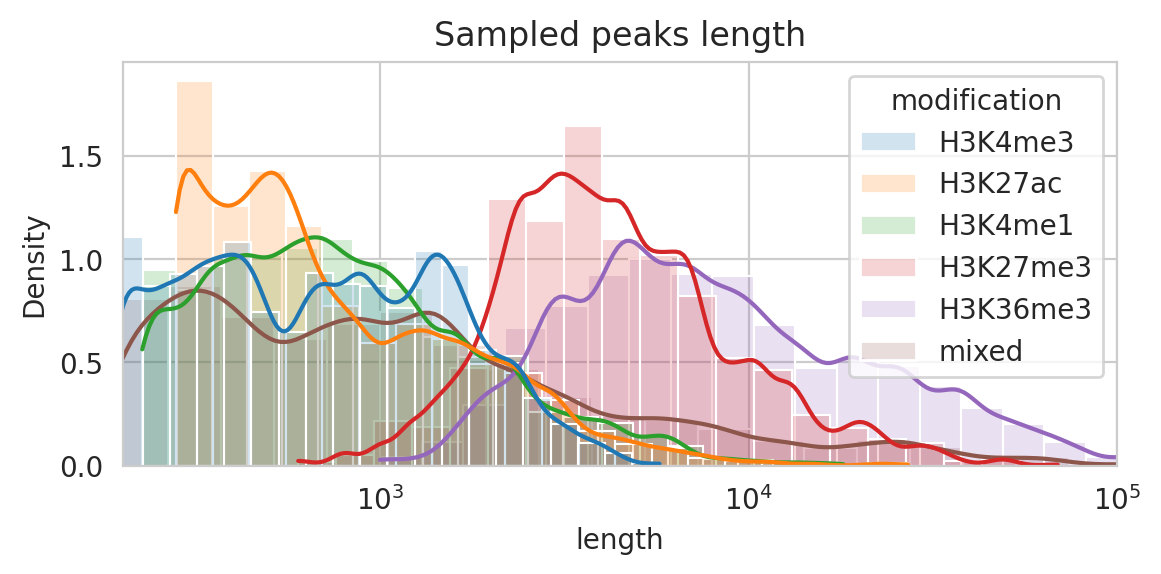

In [43]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
g_results = sns.histplot(data=t_true_peaks, x='length', hue='modification', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=20, kde=True, log_scale=True, alpha=0.2,
                         hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
g_results.set(xscale='log')
g_results.set_xlim(200, 1e5)
ax.title.set_text('Sampled peaks length')
plt.savefig(os.path.join(FIGURES_DIR, f'sampled_peaks_lengths2.pdf'), bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

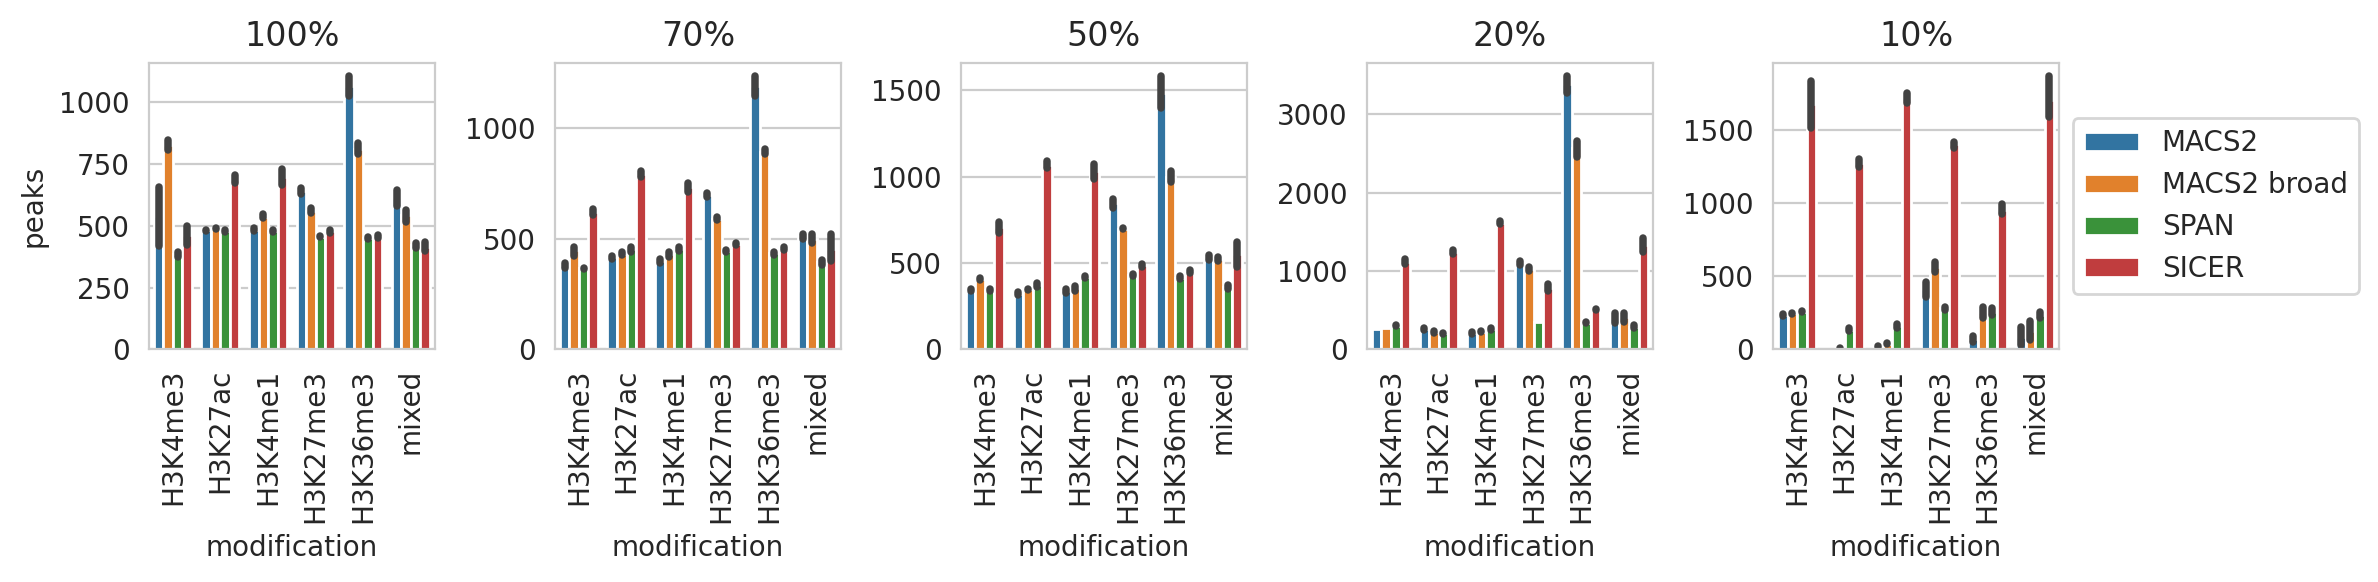

In [44]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, q in enumerate(df_peaks['quality'].unique()):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['quality'] == q], x="modification", y="peaks", hue='tool', ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
                hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == len(axs) - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'peaks.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [45]:
df_peaks[(df_peaks['quality'] == '100%') & (df_peaks['modification'] == 'H3K36me3')]

file modification  n  \
100  /home/jetbrains/data/2023_chips/macs2/H3K36me3...     H3K36me3  1   
105  /home/jetbrains/data/2023_chips/macs2/H3K36me3...     H3K36me3  2   
110  /home/jetbrains/data/2023_chips/macs2/H3K36me3...     H3K36me3  3   
115  /home/jetbrains/data/2023_chips/macs2/H3K36me3...     H3K36me3  4   
120  /home/jetbrains/data/2023_chips/macs2/H3K36me3...     H3K36me3  5   
250  /home/jetbrains/data/2023_chips/macs2/H3K36me3...     H3K36me3  1   
255  /home/jetbrains/data/2023_chips/macs2/H3K36me3...     H3K36me3  2   
260  /home/jetbrains/data/2023_chips/macs2/H3K36me3...     H3K36me3  3   
265  /home/jetbrains/data/2023_chips/macs2/H3K36me3...     H3K36me3  4   
270  /home/jetbrains/data/2023_chips/macs2/H3K36me3...     H3K36me3  5   
400  /home/jetbrains/data/2023_chips/span/H3K36me3_...     H3K36me3  1   
405  /home/jetbrains/data/2023_chips/span/H3K36me3_...     H3K36me3  2   
410  /home/jetbrains/data/2023_chips/span/H3K36me3_...     H3K36me3  3   
415  /home/jetbrains/data/2023_chips/span/H3K36me3_...     H3K36me3  4   
420  /home/jetbrains/data/2023_chips/span/H3K36me3_...     H3K36me3  5   
550  /home/jetbrains/data/2023_chips/sicer/H3K36me3...     H3K36me3  1   
555  /home/jetbrains/data/2023_chips/sicer/H3K36me3...     H3K36me3  2   
560  /home/jetbrains/data/2023_chips/sicer/H3K36me3...     H3K36me3  3   
565  /home/jetbrains/data/2023_chips/sicer/H3K36me3...     H3K36me3  4   
570  /home/jetbrains/data/2023_chips/sicer/H3K36me3...     H3K36me3  5   

     multiplier         tool quality  \
100         1.0        MACS2    100%   
105         1.0        MACS2    100%   
110         1.0        MACS2    100%   
115         1.0        MACS2    100%   
120         1.0        MACS2    100%   
250         1.0  MACS2 broad    100%   
255         1.0  MACS2 broad    100%   
260         1.0  MACS2 broad    100%   
265         1.0  MACS2 broad    100%   
270         1.0  MACS2 broad    100%   
400         1.0         SPAN    100%   
405         1.0         SPAN    100%   
410         1.0         SPAN    100%   
415         1.0         SPAN    100%   
420         1.0         SPAN    100%   
550         1.0        SICER    100%   
555         1.0        SICER    100%   
560         1.0        SICER    100%   
565         1.0        SICER    100%   
570         1.0        SICER    100%   

                                       true_peaks_file  true_peaks  \
100  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
105  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
110  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
115  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
120  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
250  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
255  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
260  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
265  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
270  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
400  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
405  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
410  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
415  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
420  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
550  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
555  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
560  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
565  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
570  /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   

     true_length  peaks     length  true_overlap  overlap  overlap_len  \
100      6868300   1099  5665263.0           334     1099      5650777   
105      6744700   1014  5599723.0 

In [46]:
ts = []
for _, (m, q, tool, file) in df_peaks[['modification', 'quality', 'tool', 'file']].iterrows():
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 20_000))
    t['modification'] = m
    t['quality'] = q
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t

length modification quality   tool
0        193.0      H3K4me3    100%  MACS2
1        193.0      H3K4me3    100%  MACS2
2       2627.0      H3K4me3    100%  MACS2
3        209.0      H3K4me3    100%  MACS2
4        432.0      H3K4me3    100%  MACS2
...        ...          ...     ...    ...
355520   599.0        mixed     10%  SICER
355521  1399.0        mixed     10%  SICER
355522   999.0        mixed     10%  SICER
355523  2199.0        mixed     10%  SICER
355524  1799.0        mixed     10%  SICER

[355525 rows x 4 columns]

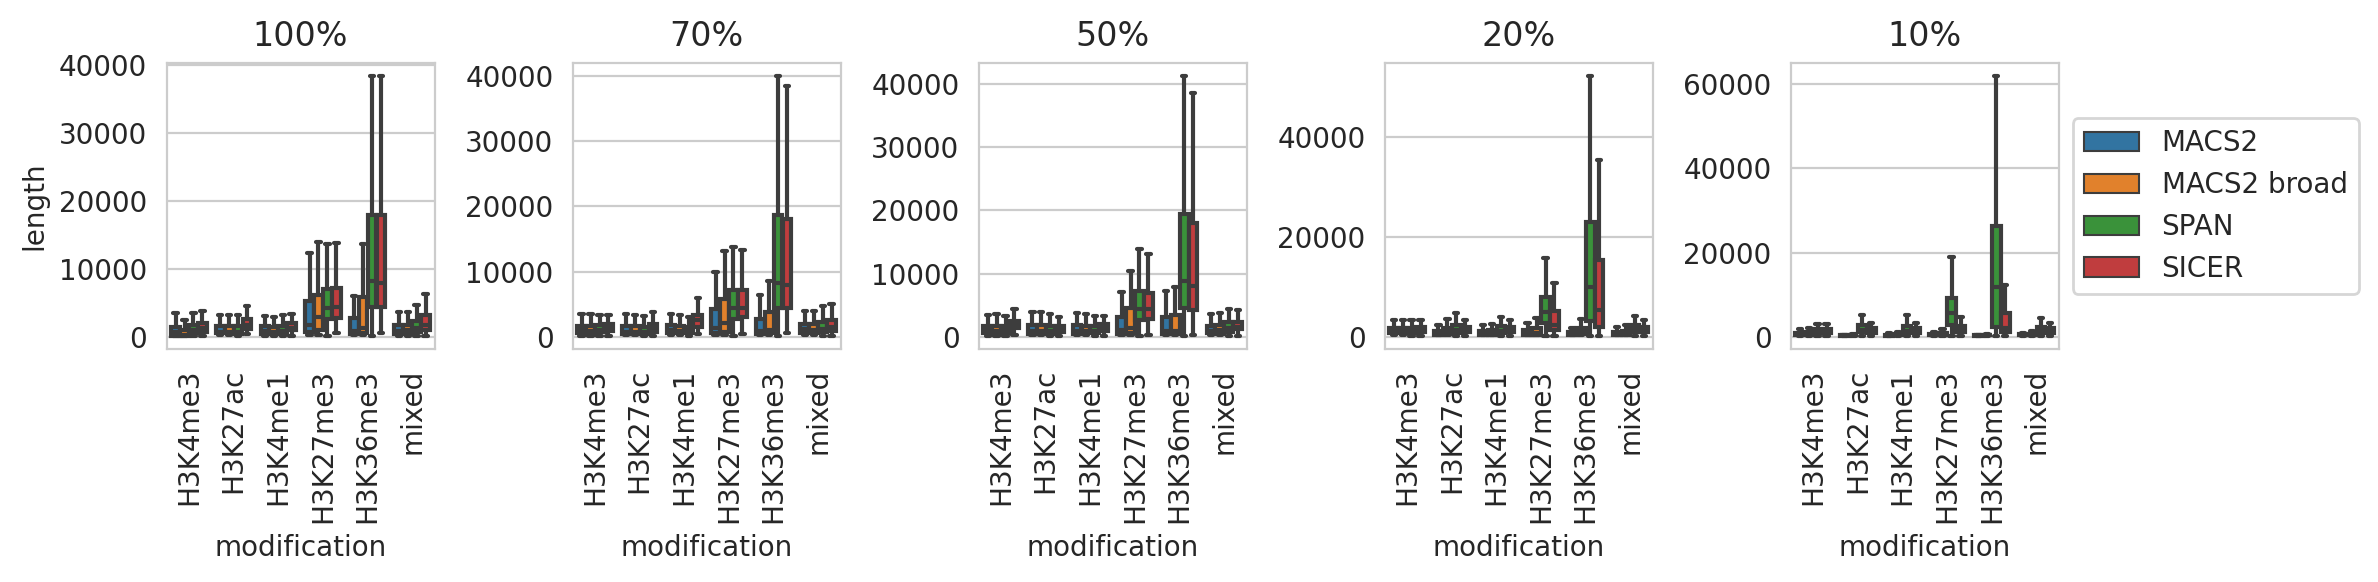

In [47]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, q in enumerate(df_peaks['quality'].unique()):
    ax = axs[i]
    sns.boxplot(data=t[t['quality']==q], x="modification", y="length", hue='tool', showfliers=False, ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
                hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == len(axs) - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Jaccard, precision, recall, F1

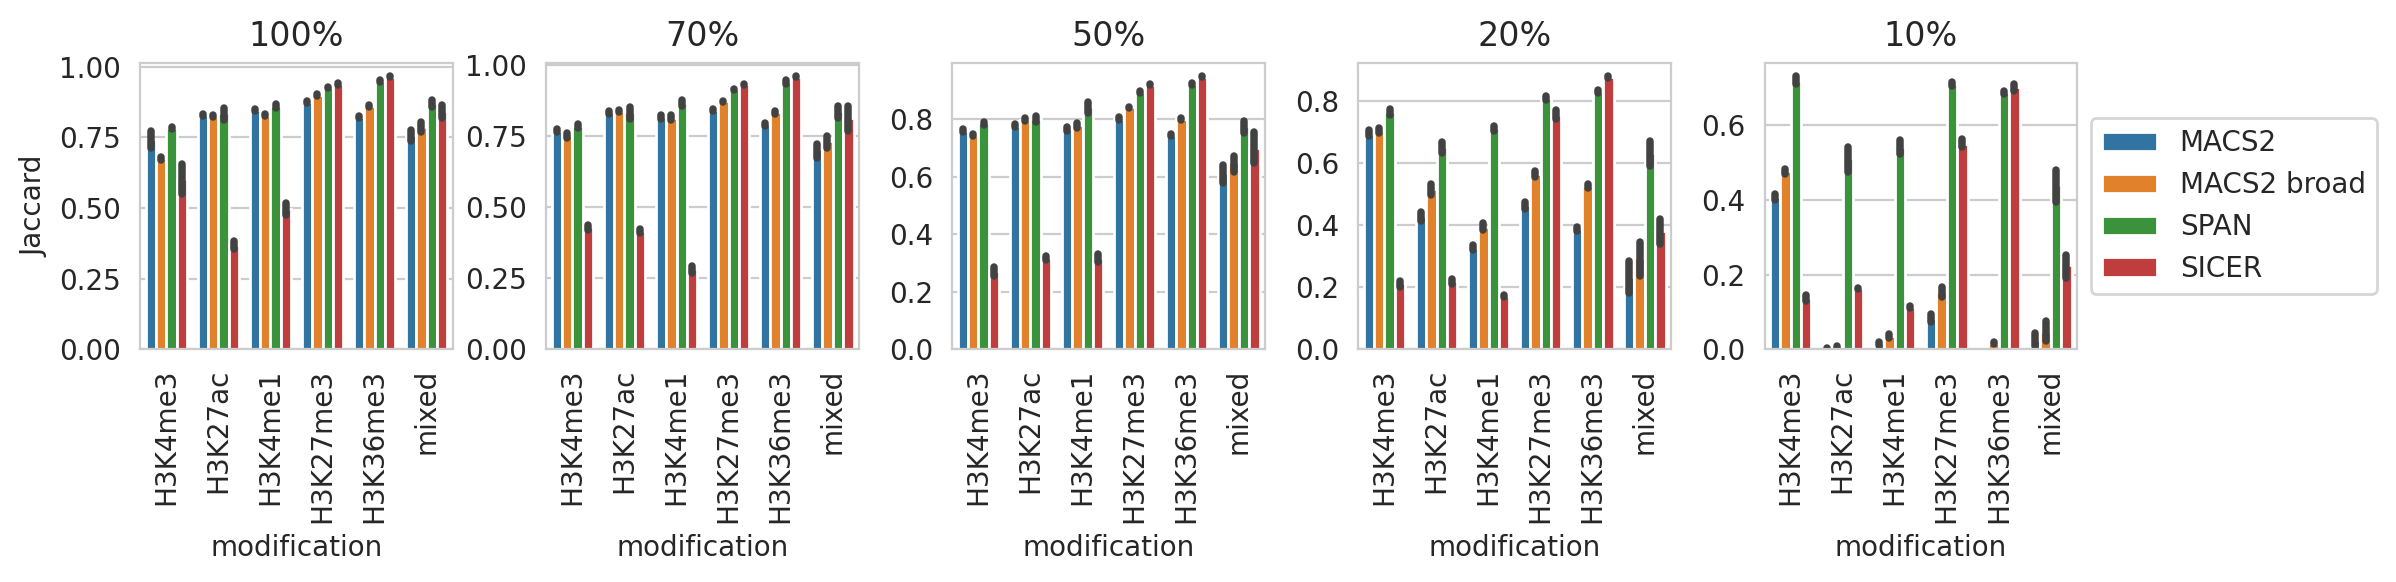

In [48]:
plt.figure(figsize=(12, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, q in enumerate(df_peaks['quality'].unique()):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['quality'] == q], x="modification", y="Jaccard", hue='tool', ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
                hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == len(axs) - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [49]:
df_peaks0 = df_peaks.copy()
# Add 0.0 multiplier
for m, tool in product(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'], TOOLS):
    row = [None, m, None, 0.0, tool, '0%'] + [None] * (len(df_peaks.columns) - 7) + [0.0]
    df_peaks0.loc[len(df_peaks0)] = row
df_peaks0

file modification     n  \
0    /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
1    /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
2    /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
3    /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
4    /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
..                                                 ...          ...   ...   
619                                               None     H3K36me3  None   
620                                               None        mixed  None   
621                                               None        mixed  None   
622                                               None        mixed  None   
623                                               None        mixed  None   

     multiplier         tool quality  \
0           1.0        MACS2    100%   
1           0.7        MACS2     70%   
2           0.5        MACS2     50%   
3           0.2        MACS2     20%   
4           0.1        MACS2     10%   
..          ...          ...     ...   
619         0.0        SICER      0%   
620         0.0        MACS2      0%   
621         0.0  MACS2 broad      0%   
622         0.0         SPAN      0%   
623         0.0        SICER      0%   

                                       true_peaks_file true_peaks true_length  \
0    /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500      446051   
1    /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500      446051   
2    /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500      446051   
3    /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500      446051   
4    /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500      446051   
..                                                 ...        ...         ...   
619                                               None       None        None   
620                                               None       None        None   
621                                               None       None        None   
622                                               None       None        None   
623                                               None       None        None   

    peaks    length true_overlap overlap overlap_len Precision Recall  \
0     724  553939.0          398     401      408267  0.553867  0.796   
1     394  463046.0          359     367      393356  0.931472  0.718   
2     345  432379.0          329     335      378729  0.971014  0.658   
3     258  358434.0          253     256      327744  0.992248  0.506   
4     238  195186.0          184     235      187942  0.987395  0.368   
..    ...       ...          ...     ...         ...       ...    ...   
619  None      None         None    None        None      None   None   
620  None      None         None    None        None      None   None   
621  None      None         None    None        None      None   None   
622  None      None         None    None        None      None   None   
623  None      None         None    None        None      None   None   

           F1   Jaccard  
0    0.653217  0.689963  
1    0.810922  0.762701  
2    0.784434  0.757911  
3    0.670219  0.687468  
4     0.53617  0.414613  
..        ...       ...  
619      None  0.000000  
620      None  0.000000  
621      None  0.000000  
622      None  0.000000  
623      None  0.000000  

[624 rows x 18 columns]

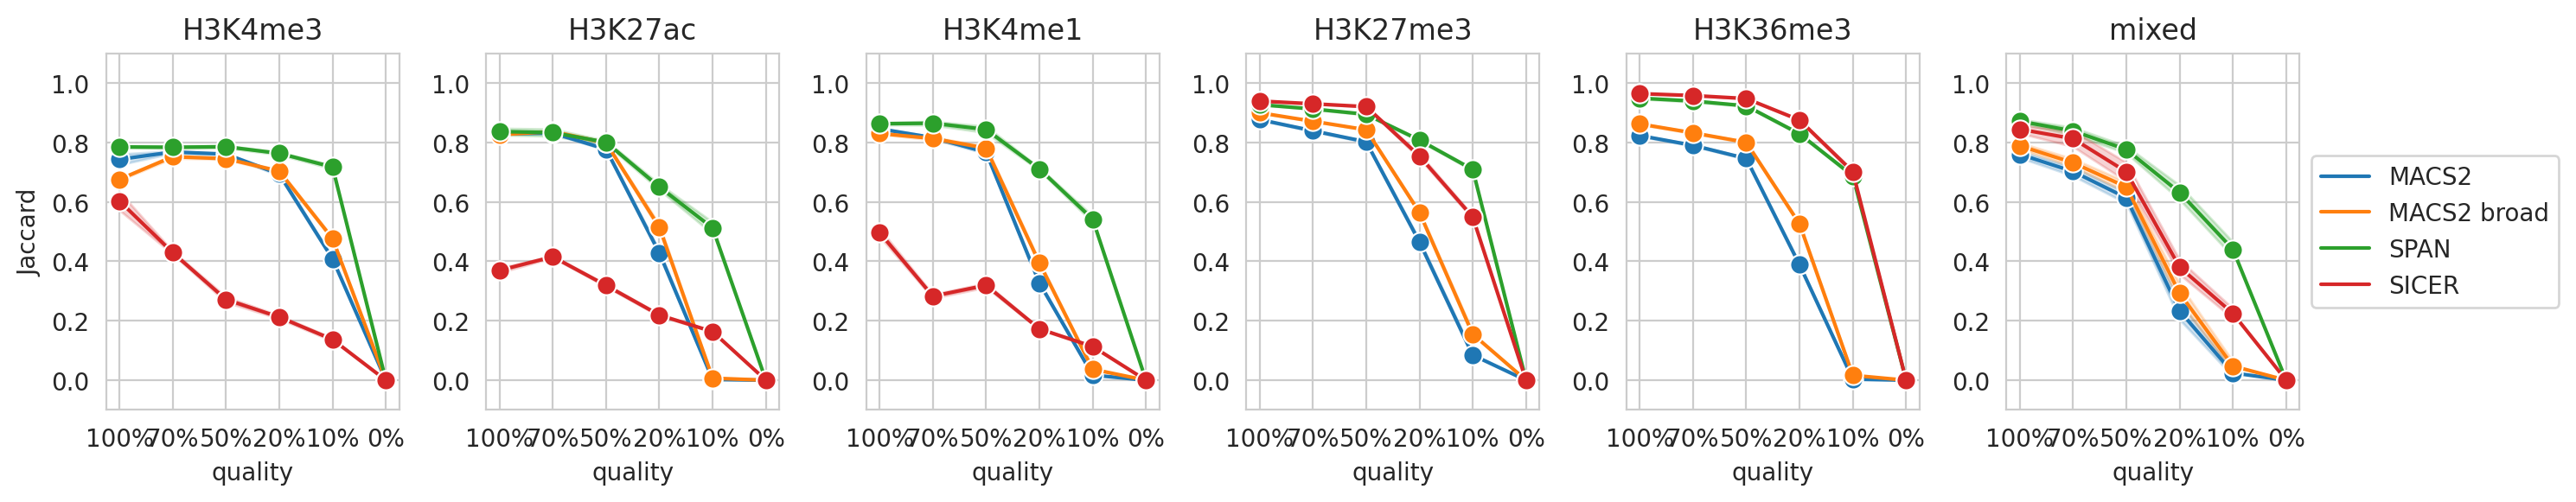

In [74]:
plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed']):
    ax = axs[i]
    sns.lineplot(data=df_peaks0[df_peaks0['modification'] == m], x="quality", y="Jaccard", hue='tool', ax=ax,
                 hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                 palette=TOOLS_PALETTE,
                 errorbar='se',
                 marker='o', markersize=8)
    ax.set_title(f'{m}')
    ax.set_ylim([-0.1, 1.1])
    # Put a legend to the right of the current axis
    if i == 5:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'jaccard2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

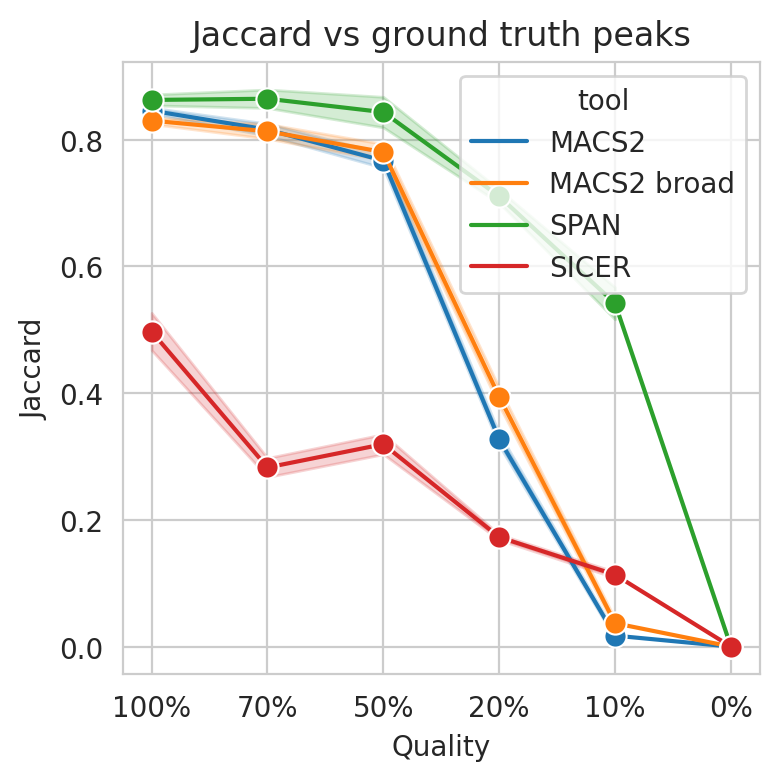

In [51]:
plt.figure(figsize=(4, 4))
sns.lineplot(data=df_peaks0[df_peaks0['modification'] == 'H3K4me1'], x="quality", y="Jaccard", hue='tool',
             hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
             palette=TOOLS_PALETTE,
             errorbar='sd', marker='o', markersize=8)
plt.title('Jaccard vs ground truth peaks')
plt.xlabel('Quality')
plt.ylabel('Jaccard')
plt.tight_layout()
plt.show()

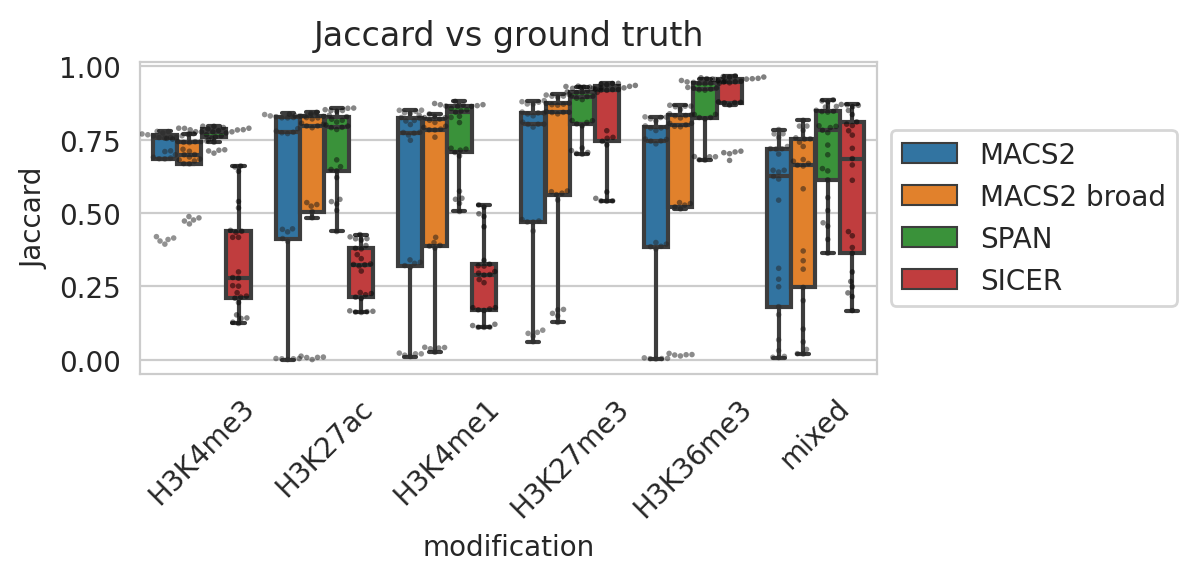

In [52]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.boxplot(data=df_peaks[df_peaks['multiplier'] > 0],
            x='modification', y='Jaccard', hue='tool',
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            palette=TOOLS_PALETTE,
            showfliers=False,
            ax=ax)
sns.swarmplot(data=df_peaks[df_peaks['multiplier'] > 0],
              x='modification', y='Jaccard', hue='tool',
              dodge=True, size=2, color="black", alpha=0.5, palette='dark:black',
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
              legend=False,
              ax=ax)
ax.set_title('Jaccard vs ground truth')
ax.xaxis.set_tick_params(rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard3.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Jaccard AUC vs quality

In [53]:
t = []
for (m, n, tool), dft in tqdm(list(df_peaks0[df_peaks0['quality'] != '0%'].groupby(['modification', 'n', 'tool']))):
    aj = 0
    mprev = 0
    jprev = 0
    for _, row in dft.sort_values(by=['multiplier']).iterrows():
        aj += (row['multiplier'] - mprev) * (row['Jaccard'] + jprev) / 2
        mprev, jprev = row['multiplier'], row['Jaccard']
    t.append((m, n, tool, aj))
dfjaccardauc = pd.DataFrame(data=t, columns=['modification', 'n', 'tool', 'AUC'])
dfjaccardauc.sample(3)

  0%|          | 0/120 [00:00<?, ?it/s]

modification  n         tool       AUC
73       H3K4me1  4  MACS2 broad  0.609312
106        mixed  2        SICER  0.529205
117        mixed  5  MACS2 broad  0.527345

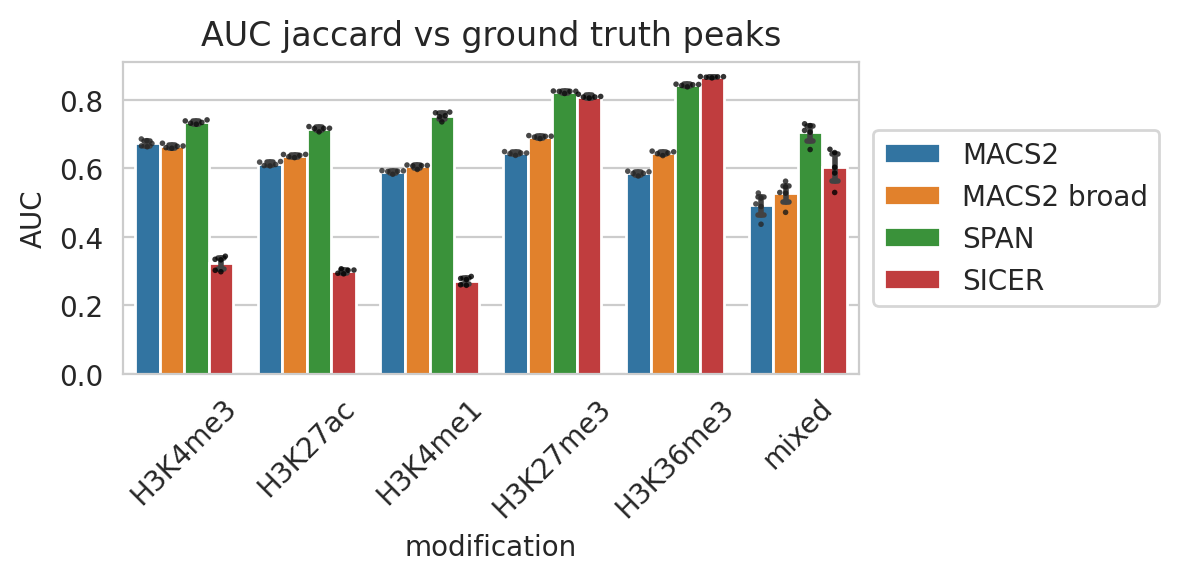

In [54]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.title.set_text('AUC jaccard vs ground truth peaks')
sns.barplot(data=dfjaccardauc, x='modification', y='AUC',hue='tool',
            capsize=.05, errwidth=2,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=dfjaccardauc, x='modification', y='AUC',hue='tool',
              dodge=True, size=2, color="black", alpha=0.8, palette='dark:black',
              order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.xaxis.set_tick_params(rotation=45)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard_auc2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

Precision


/home/jetbrains/miniconda3/envs/pubtrends/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


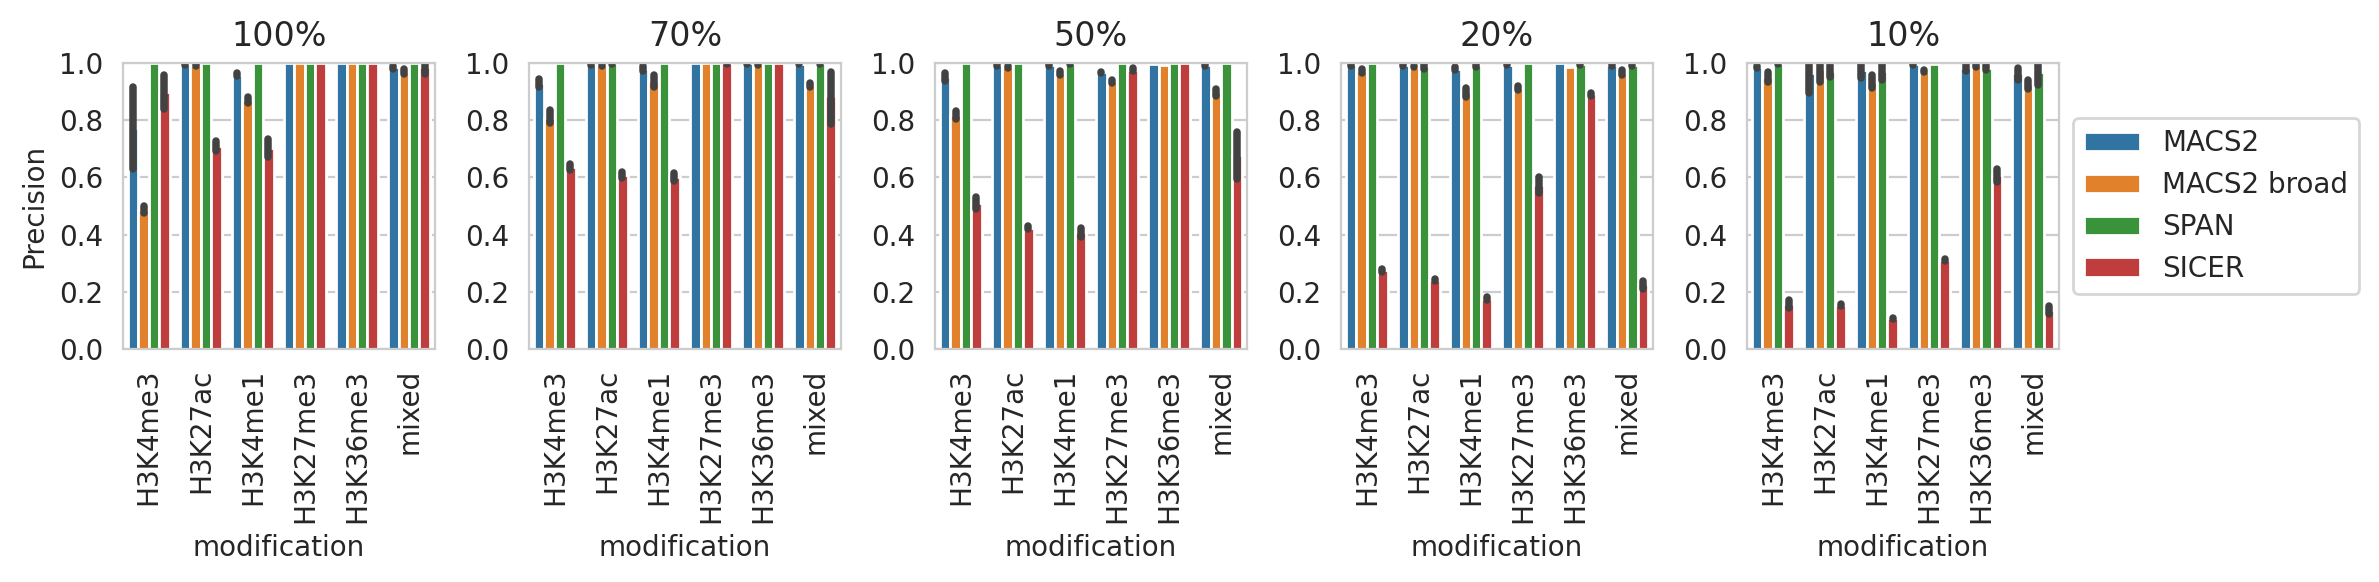

Recall


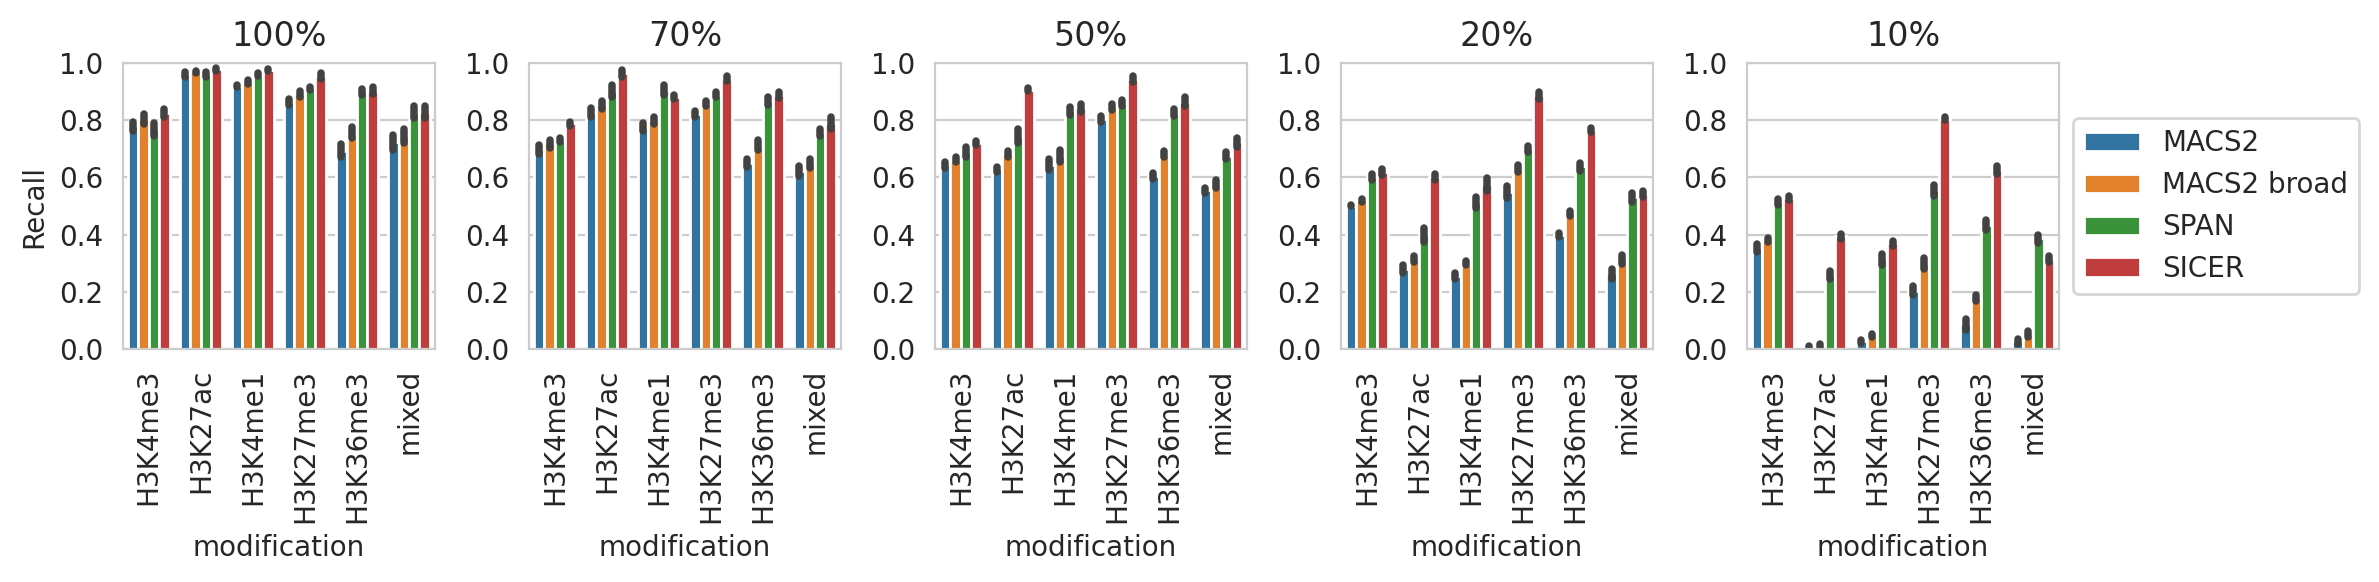

F1


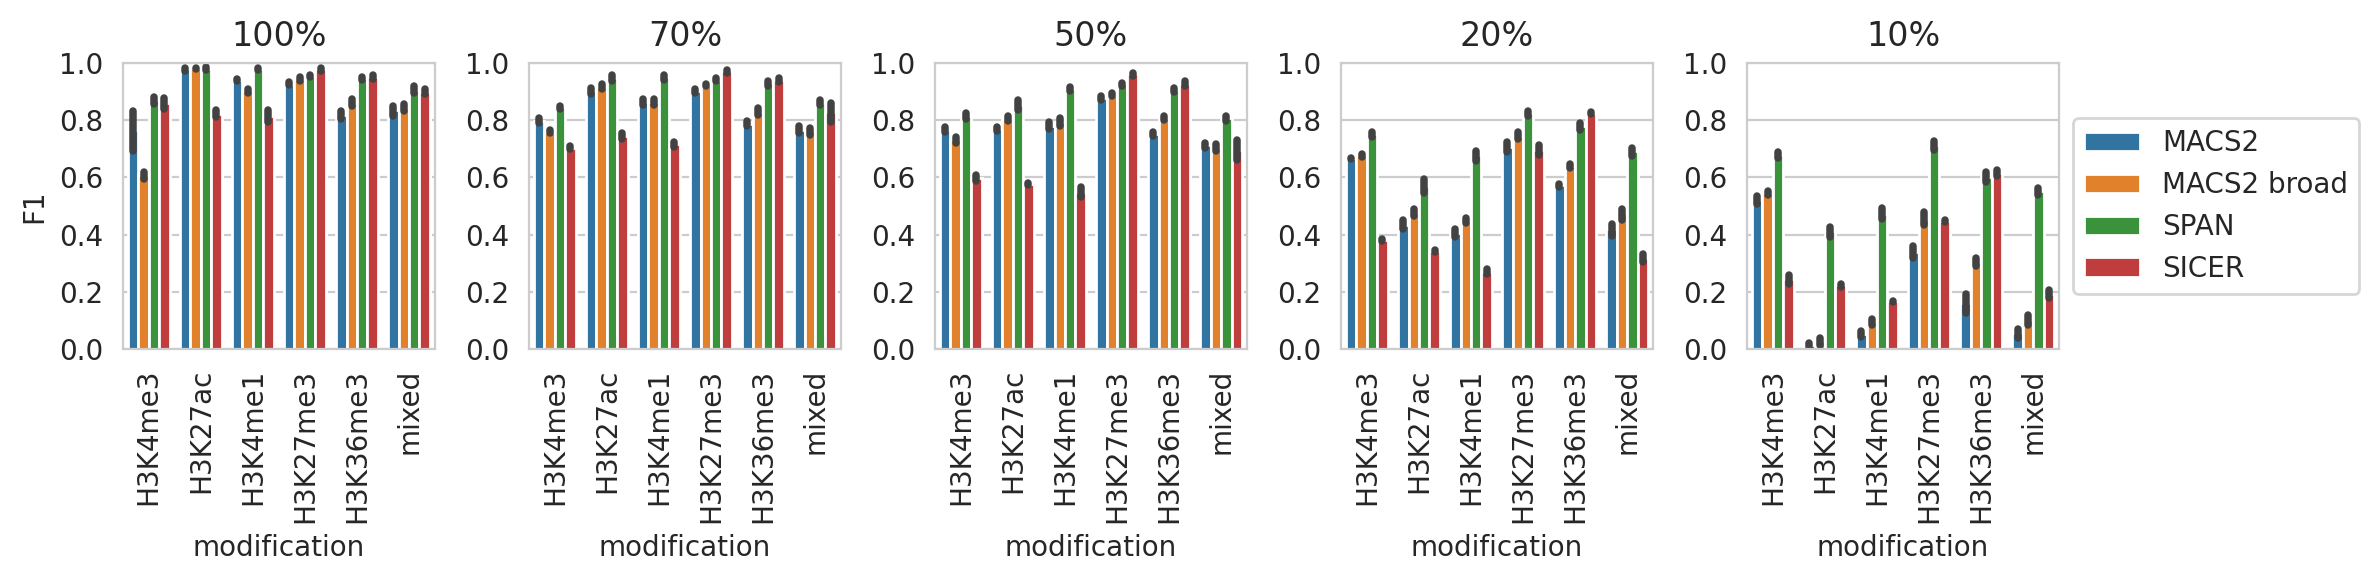

In [55]:
for y in ['Precision', 'Recall', 'F1']:
    print(y)
    plt.figure(figsize=(12, 3))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, q in enumerate(df_peaks['quality'].unique()):
        if q == '0%':
            continue
        ax = axs[i]
        sns.barplot(data=df_peaks[(df_peaks['quality'] == q)], x="modification", y=y, hue='tool', ax=ax,
                    order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
        ax.xaxis.set_tick_params(rotation=90)
        ax.set_title(f'{q}')
        # Put a legend to the right of the current axis
        if i == len(axs) - 1:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().set_visible(False)
        if i > 0:
            ax.set_ylabel(None)
        ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'{y}.pdf'), bbox_inches='tight', dpi=300)
    plt.show()

/tmp/ipykernel_83572/1893111183.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('tab10')


  0%|          | 0/6 [00:00<?, ?it/s]

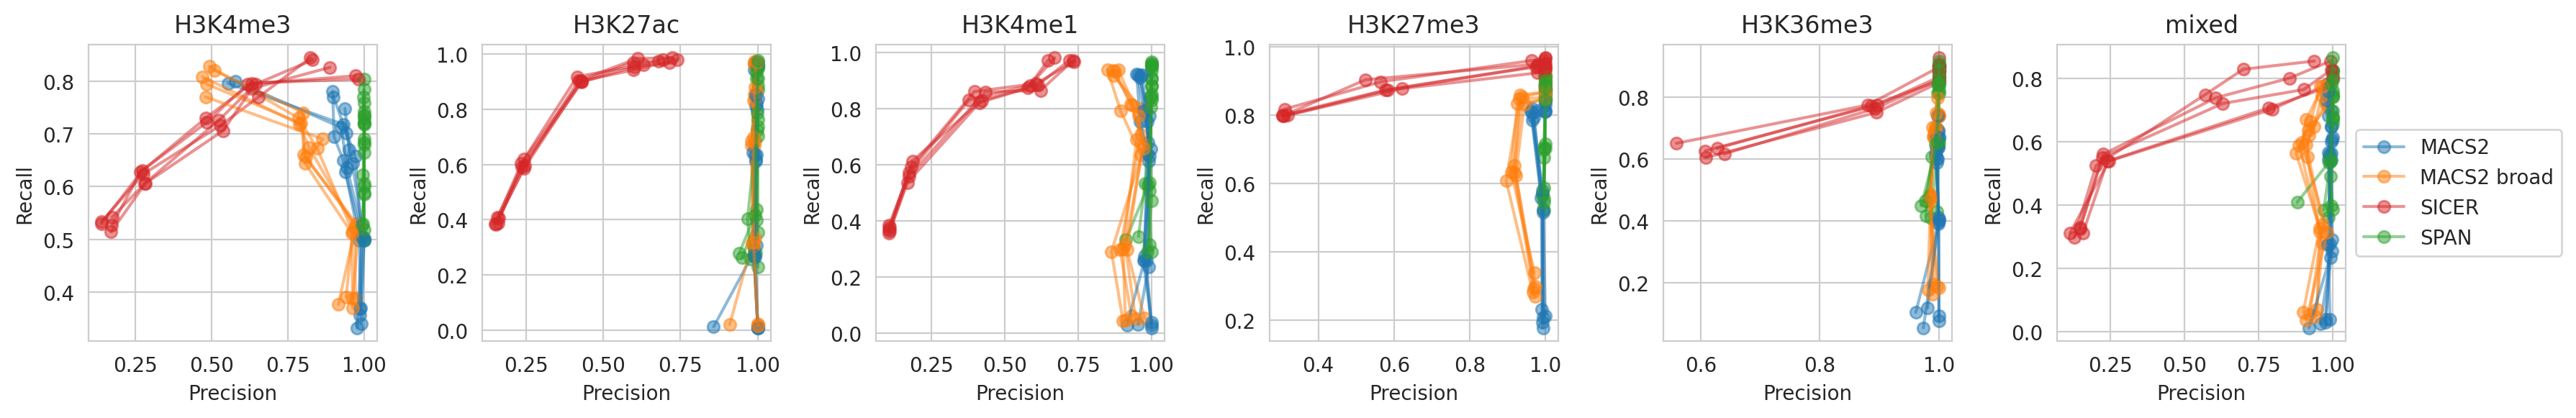

In [56]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

plt.figure(figsize=(18, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
labels = []  # Hack to add labels only once
for i, m in enumerate(tqdm(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])):
    ax = axs[i]
    for (n, tool), dft in df_peaks[df_peaks['modification'] == m].groupby(['n', 'tool']):
        if m == 'mixed' and tool not in labels:
            ax.plot(dft['Precision'], dft['Recall'], marker='o', label=tool, color=TOOLS_PALETTE[tool], alpha=0.5)
            labels.append(tool)
        else:
            ax.plot(dft['Precision'], dft['Recall'], marker='o', color=TOOLS_PALETTE[tool], alpha=0.5)
        ax.set_xlabel('Precision')
        ax.set_ylabel('Recall')
        ax.set_title(f'{m}')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'auc.pdf'), bbox_inches='tight', dpi=300)
plt.show()

/tmp/ipykernel_83572/1888415738.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('tab10')


  0%|          | 0/6 [00:00<?, ?it/s]

/tmp/ipykernel_83572/1888415738.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (tool), dft in df_peaks[df_peaks['modification'] == m].groupby(['tool']):
/tmp/ipykernel_83572/1888415738.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (tool), dft in df_peaks[df_peaks['modification'] == m].groupby(['tool']):
/tmp/ipykernel_83572/1888415738.py:10: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for (tool), dft in df_peaks[df_peaks['modification'] == m].group

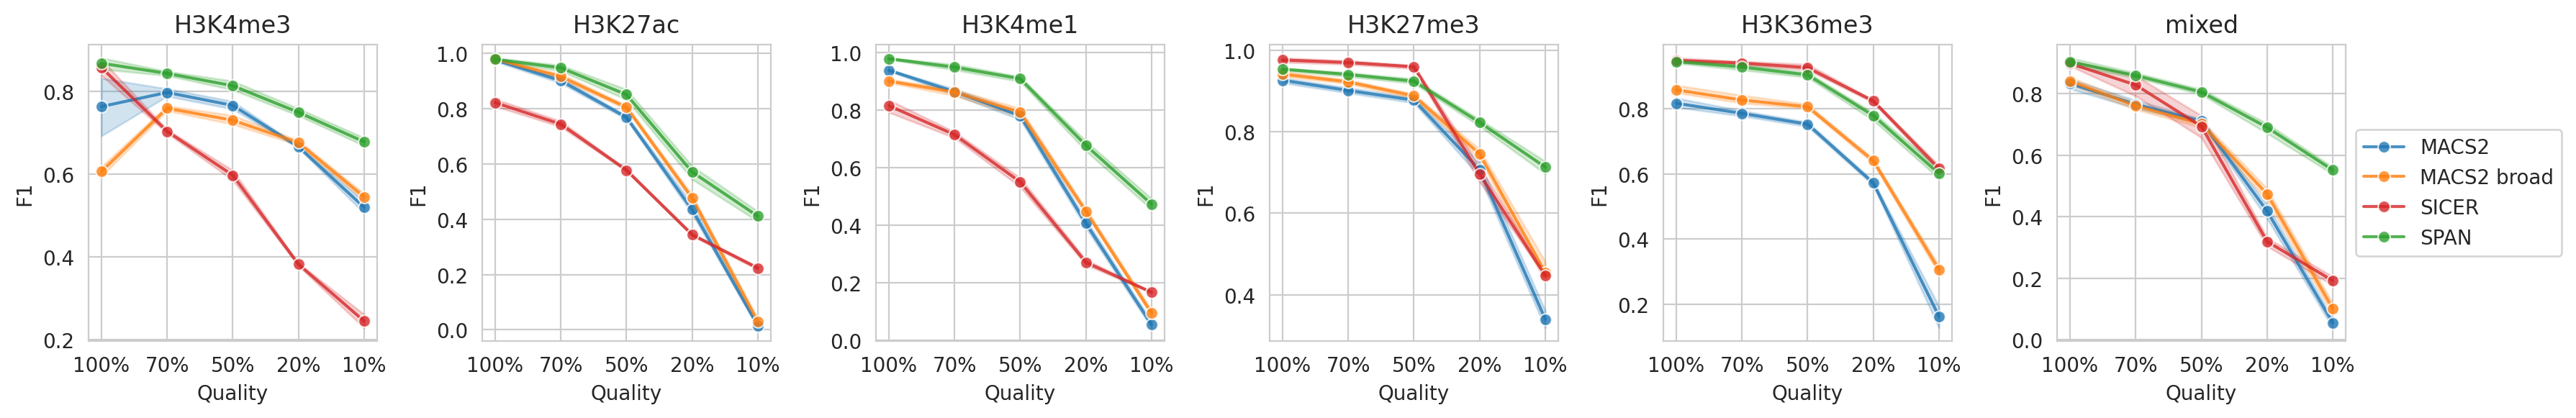

In [57]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

plt.figure(figsize=(18, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
labels = []  # Hack to add labels only once 
for i, m in enumerate(tqdm(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])):
    ax = axs[i]
    for (tool), dft in df_peaks[df_peaks['modification'] == m].groupby(['tool']):
        if m == 'mixed' and tool not in labels:
            sns.lineplot(dft, x='quality', y='F1', marker='o', label=tool, color=TOOLS_PALETTE[tool], alpha=0.8, ax=ax)
            labels.append(tool)
        else:
            sns.lineplot(dft, x='quality', y='F1', marker='o', label=tool, color=TOOLS_PALETTE[tool], alpha=0.8, ax=ax)
    ax.set_xlabel('Quality')
    ax.set_ylabel('F1')
    ax.set_title(f'{m}')
    # Put a legend to the right of the current axis
    if i == 5:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))        
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'auc.pdf'), bbox_inches='tight', dpi=300)
plt.show()

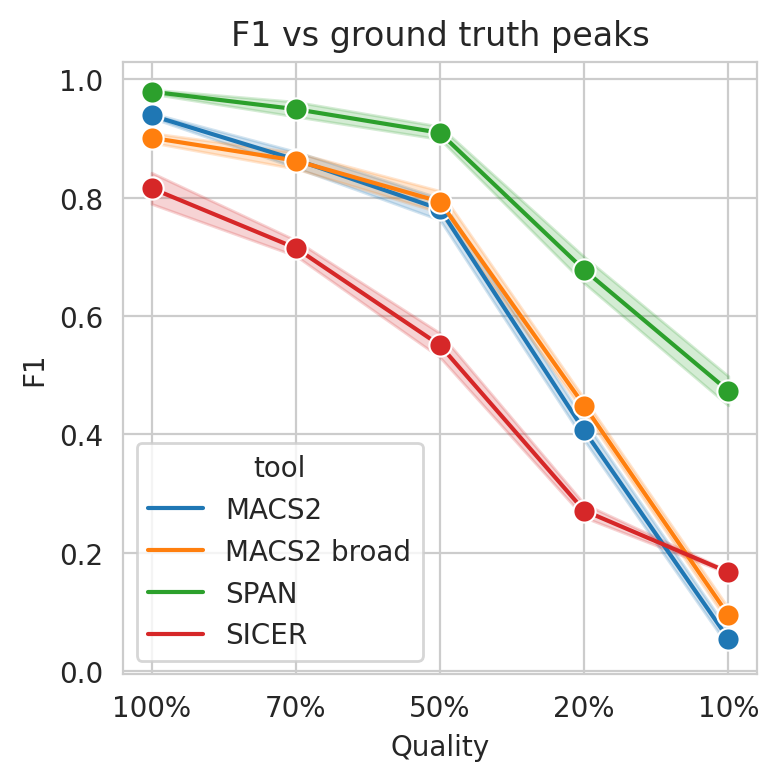

In [58]:
plt.figure(figsize=(4, 4))
sns.lineplot(data=df_peaks[df_peaks['modification'] == 'H3K4me1'], x="quality", y="F1", hue='tool',
             hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
             palette=TOOLS_PALETTE,
             errorbar='sd', marker='o', markersize=8)
plt.title('F1 vs ground truth peaks')
plt.xlabel('Quality')
plt.ylabel('F1')
plt.tight_layout()
plt.show()

In [59]:
t = []
for (m, n, tool), dft in tqdm(list(df_peaks0[df_peaks0['quality'] != '0%'].groupby(['modification', 'n', 'tool']))):
    aj = 0
    mprev = 0
    f1prev = 0
    for _, row in dft.sort_values(by=['multiplier']).iterrows():
        aj += (row['multiplier'] - mprev) * (row['F1'] + f1prev) / 2
        mprev, f1prev = row['multiplier'], row['F1']
    t.append((m, n, tool, aj))
dff1auc = pd.DataFrame(data=t, columns=['modification', 'n', 'tool', 'AUC'])
dff1auc.sample(3)

  0%|          | 0/120 [00:00<?, ?it/s]

modification  n   tool       AUC
6       H3K27ac  2  SICER  0.546485
44     H3K36me3  2  MACS2  0.645639
23     H3K27me3  1   SPAN  0.844651

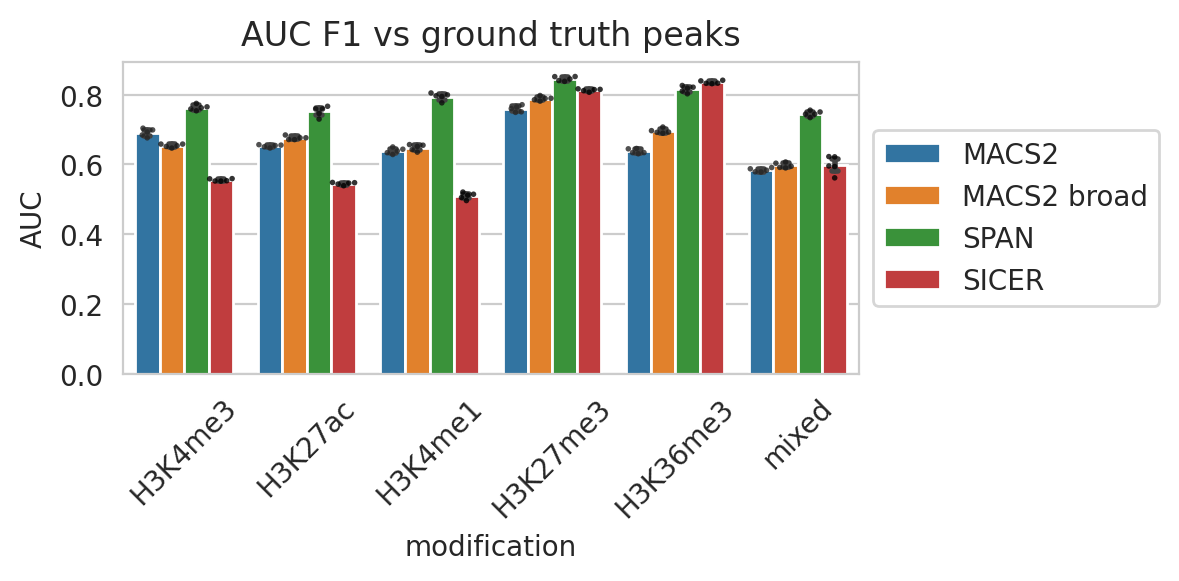

In [60]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.title.set_text('AUC F1 vs ground truth peaks')
sns.barplot(data=dff1auc, x='modification', y='AUC',hue='tool',
            capsize=.05, errwidth=2,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=dff1auc, x='modification', y='AUC',hue='tool',
              dodge=True, size=2, color="black", alpha=0.8,
              palette="dark:black",
              order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.xaxis.set_tick_params(rotation=45)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'jaccard_auc2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Overlap vs 100% quality peaks

In [ ]:
rows = []
tf = tempfile.mktemp()
for (m, n, t), dft in tqdm(df_peaks.groupby(['modification', 'n', 'tool'])):
    print(m, n, t)
    peaks_file100 = dft[dft['multiplier'] == 1.0]['file'].values[0]
    for _, (file, mult) in dft[dft['multiplier'] != 1.0][['file', 'multiplier']].iterrows():
        peaks100 = lines(peaks_file100)
        length100 = bedl(peaks_file100).sum()
        peaks = lines(file)
        length = bedl(file).sum()
        peaks_file100_s = sorted_file(peaks_file100)
        file_s = sorted_file(file)
        !bedtools intersect -a {peaks_file100_s} -b {file_s} -wa -u > {tf}
        overlap100 = lines(tf)
        !bedtools intersect -b {peaks_file100_s} -a {file_s} -wa -u > {tf}
        overlap = lines(tf)
        !bedtools intersect -a {peaks_file100_s} -b {file_s} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        rows.append((m, n, t, mult, peaks_file100, peaks100, length100, peaks, length, overlap100, overlap, overlap_len))

overlap100_df = pd.DataFrame(rows, columns=['modification', 'n', 'tool', 'multiplier',
                             'peaks_file100', 'peaks100', 'length100',
                             'peaks', 'length',
                             'overlap100', 'overlap', 'overlap_len'])
del rows

overlap100_df['Precision'] = overlap100_df['overlap'] / overlap100_df['peaks']
overlap100_df['Recall'] = overlap100_df['overlap100'] / overlap100_df['peaks100']
overlap100_df['F1'] = [2 / (1 / p + 1 / r) if min(p, r) > 0 else 0 for p, r in zip(overlap100_df['Precision'], overlap100_df['Recall'])]
overlap100_df['Jaccard'] = overlap100_df['overlap_len'] / (overlap100_df['length100'] + overlap100_df['length'] - overlap100_df['overlap_len'])
overlap100_df['quality'] = [f'{int(m * 100)}%' for m in overlap100_df['multiplier']]

overlap100_df.sample(3)

In [65]:
overlap100_df0 = overlap100_df.copy()
# Add 1.0 and 0.0 multiplier
for m, n, tool in product(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'], range(1, 6), TOOLS):
    row = [m, n, tool, 0.0] + [None] * (len(overlap100_df0.columns) - 4)
    overlap100_df0.loc[len(overlap100_df0)] = row
    row = [m, n, tool, 1.0] + [None] * (len(overlap100_df0.columns) - 4)
    overlap100_df0.loc[len(overlap100_df0)] = row
    
overlap100_df0.loc[overlap100_df0['multiplier'] == 0, 'quality'] = '0%'
overlap100_df0.loc[overlap100_df0['multiplier'] == 1.0, 'quality'] = '100%'
overlap100_df0.loc[overlap100_df0['multiplier'] == 0, 'Jaccard'] = 0
overlap100_df0.loc[overlap100_df0['multiplier'] == 1.0, 'Jaccard'] = 1
overlap100_df0.sort_values(by=['modification', 'n', 'tool', 'multiplier'], ascending=False, inplace=True)
overlap100_df0.tail(3)

modification  n   tool  multiplier  \
2        H3K27ac  1  MACS2         0.2   
3        H3K27ac  1  MACS2         0.1   
520      H3K27ac  1  MACS2         0.0   

                                         peaks_file100 peaks100 length100  \
2    /home/jetbrains/data/2023_chips/macs2/H3K27ac_...      479    646060   
3    /home/jetbrains/data/2023_chips/macs2/H3K27ac_...      479    646060   
520                                               None     None      None   

    peaks    length overlap100 overlap overlap_len Precision    Recall  \
2     255  233377.0        133     252      232482  0.988235  0.277662   
3       5    1914.0          5       5        1914       1.0  0.010438   
520  None      None       None    None        None      None      None   

           F1   Jaccard quality  
2    0.433519  0.359348     20%  
3    0.020661  0.002963     10%  
520      None         0      0%

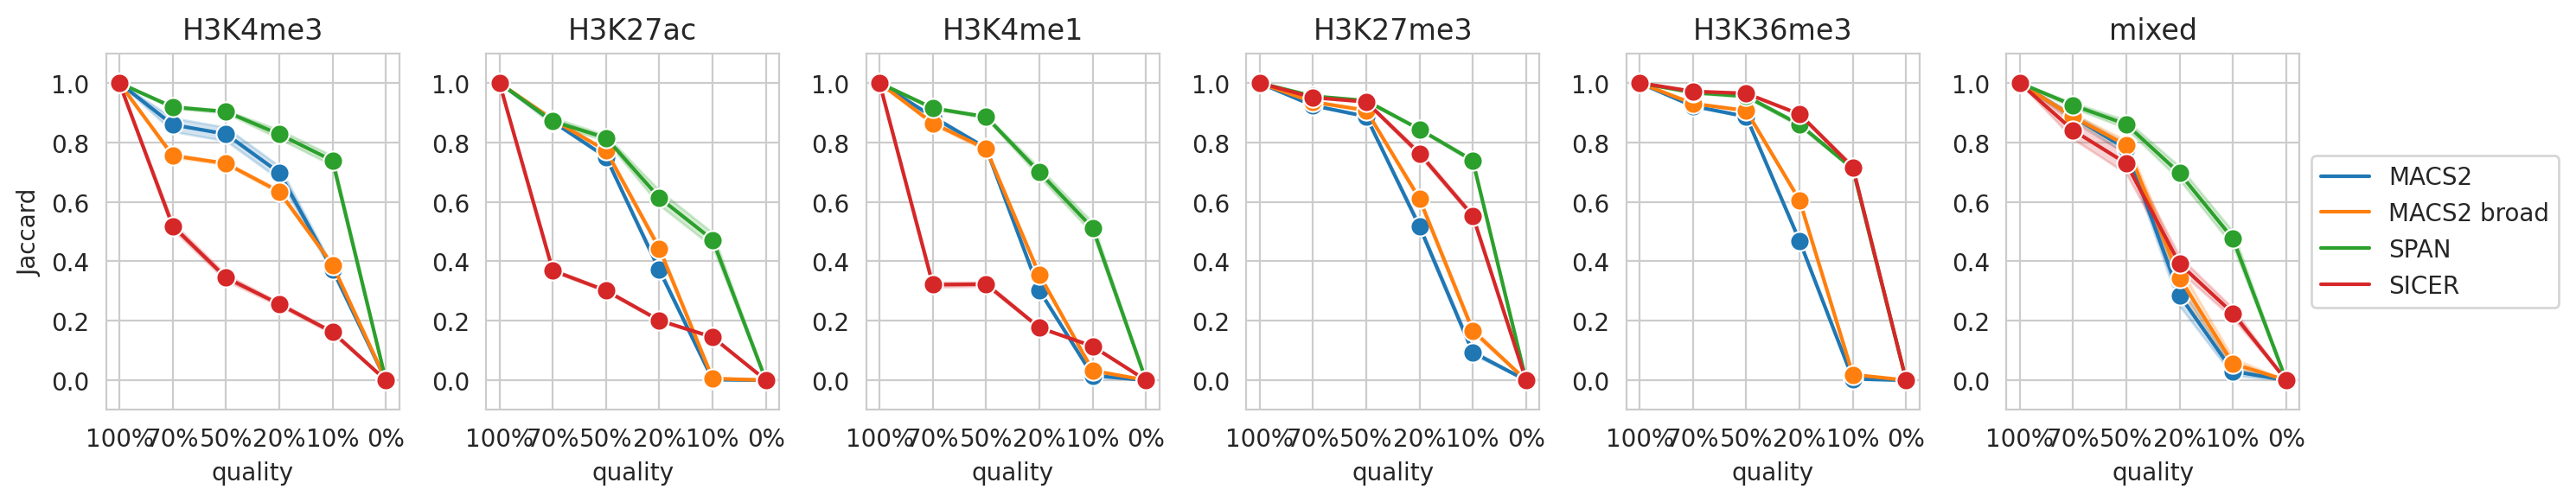

In [66]:
plt.figure(figsize=(15, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed']):
    ax = axs[i]
    sns.lineplot(data=overlap100_df0[overlap100_df0['modification'] == m], x="quality", y="Jaccard", hue='tool', ax=ax,
                 hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                 palette=TOOLS_PALETTE,
                 errorbar='se',
                 marker='o', markersize=8)
    sns.lineplot(data=overlap100_df0[overlap100_df0['modification'] == m], x="quality", y="Jaccard", hue='tool', ax=ax,
                 hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                 palette=TOOLS_PALETTE,
                 errorbar='se',
                 marker='o', markersize=8)
    
    ax.set_title(f'{m}')
    ax.set_ylim([-0.1, 1.1])
    # Put a legend to the right of the current axis
    if i == 5:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'jaccard2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

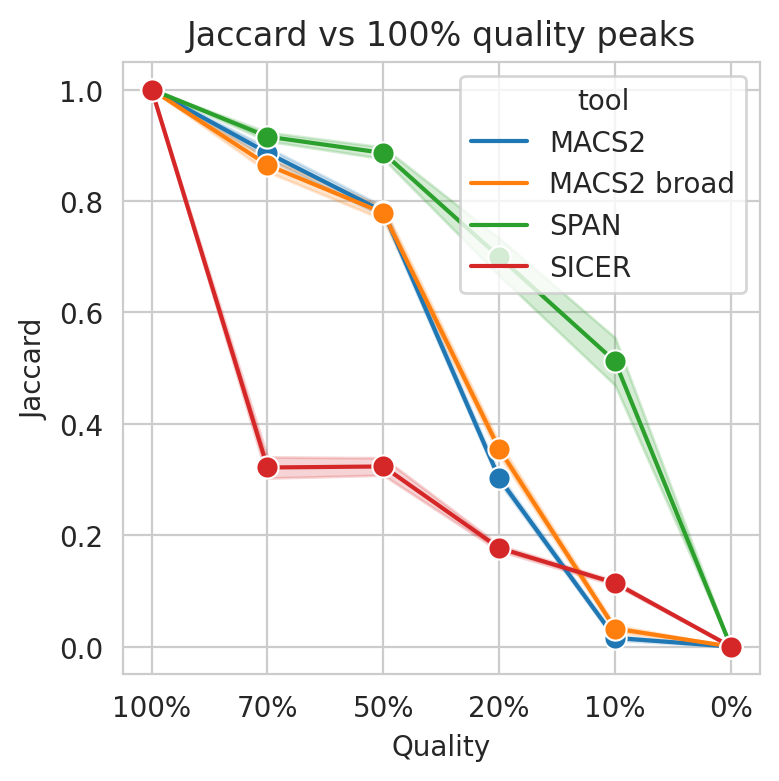

In [67]:
plt.figure(figsize=(4, 4))
sns.lineplot(data=overlap100_df0[overlap100_df0['modification'] == 'H3K4me1'], x="quality", y="Jaccard", hue='tool',
             hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
             palette=TOOLS_PALETTE,
             errorbar='sd', marker='o', markersize=8)
plt.title('Jaccard vs 100% quality peaks')
plt.xlabel('Quality')
plt.ylabel('Jaccard')
plt.tight_layout()
plt.show()

In [68]:
t = []
for (m, n, tool), dft in tqdm(list(overlap100_df0[overlap100_df0['quality'] != '0%'].groupby(['modification', 'n', 'tool']))):
    aj = 0
    mprev = 0
    jprev = 0
    for _, row in dft.sort_values(by=['multiplier']).iterrows():
        aj += (row['multiplier'] - mprev) * (row['Jaccard'] + jprev) / 2
        mprev, jprev = row['multiplier'], row['Jaccard']
    t.append((m, n, tool, aj))
dfjaccardauc100 = pd.DataFrame(data=t, columns=['modification', 'n', 'tool', 'AUC'])
dfjaccardauc100.sample(3)

  0%|          | 0/120 [00:00<?, ?it/s]

modification  n   tool       AUC
110        mixed  3  SICER  0.694138
92       H3K4me3  4  MACS2  0.775176
86       H3K4me3  2  SICER  0.441825

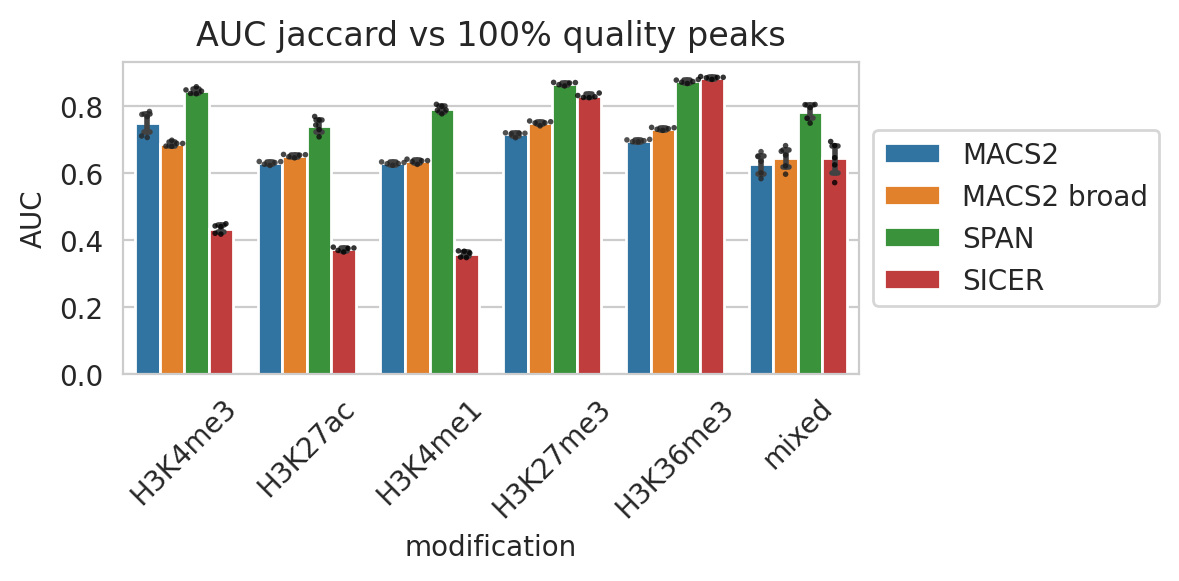

In [69]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.title.set_text('AUC jaccard vs 100% quality peaks')
sns.barplot(data=dfjaccardauc100, x='modification', y='AUC', hue='tool',
            capsize=.05, errwidth=2,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
            ax=ax)
sns.swarmplot(data=dfjaccardauc100, x='modification', y='AUC', hue='tool',
              dodge=True, size=2, color="black", alpha=0.8, palette='dark:black',
              order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
              hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'], legend=False,
              ax=ax)
ax.xaxis.set_tick_params(rotation=45)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'jaccard_auc2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [70]:
dfjaccardauc100[(dfjaccardauc100['modification'] == 'mixed') & (dfjaccardauc100['tool'] == 'SPAN')]

modification  n  tool       AUC
103        mixed  1  SPAN  0.795800
107        mixed  2  SPAN  0.749052
111        mixed  3  SPAN  0.804165
115        mixed  4  SPAN  0.804815
119        mixed  5  SPAN  0.763435